In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 3,  6,  7,  5,  0,  4,  9, 10,  2]), tensor([8, 1]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [6]:
import torch.nn as nn
linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[0.5958],
        [0.5436]], grad_fn=<AddmmBackward>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[-0.0695]], requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([0.9324], requires_grad=True)

In [9]:
x = torch.ones(1)
linear_model(x)

tensor([0.8628], grad_fn=<AddBackward0>)

In [10]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.8628],
        [0.8628],
        [0.8628],
        [0.8628],
        [0.8628],
        [0.8628],
        [0.8628],
        [0.8628],
        [0.8628],
        [0.8628]], grad_fn=<AddmmBackward>)

In [11]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)
t_u.shape

torch.Size([11, 1])

In [12]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2)

In [13]:
linear_model.parameters()

<generator object Module.parameters at 0x7f9fe6db6048>

In [14]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.6566]], requires_grad=True), Parameter containing:
 tensor([-0.5079], requires_grad=True)]

In [15]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_un_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_un_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch {}, Training Loss {}, Validation Loss {}'.format(epoch, float(loss_train), float(loss_val)))
            

In [17]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training Loss 128.27122497558594, Validation Loss 63.34524154663086
Epoch 1000, Training Loss 3.0654971599578857, Validation Loss 5.709013938903809
Epoch 2000, Training Loss 2.5728230476379395, Validation Loss 4.850105285644531
Epoch 3000, Training Loss 2.5642893314361572, Validation Loss 4.744107246398926

Parameter containing:
tensor([[5.3101]], requires_grad=True)
Parameter containing:
tensor([-16.8500], requires_grad=True)


In [18]:
seq_model = nn.Sequential(nn.Linear(1, 13), nn.Tanh(), nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [21]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_u_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training Loss 203.05882263183594, Validation Loss 115.84223175048828
Epoch 1000, Training Loss 4.93126106262207, Validation Loss 3.7012970447540283
Epoch 2000, Training Loss 5.266359329223633, Validation Loss 5.2251996994018555
Epoch 3000, Training Loss 2.8954689502716064, Validation Loss 2.4988420009613037
Epoch 4000, Training Loss 1.9970418214797974, Validation Loss 2.4528939723968506
Epoch 5000, Training Loss 1.6650428771972656, Validation Loss 2.765169382095337
output tensor([[ 6.8292],
        [11.1146]], grad_fn=<AddmmBackward>)
answer tensor([[ 6.],
        [14.]])
hidden tensor([[ 7.0252e-01],
        [ 1.4550e+01],
        [-8.7847e-03],
        [-1.4832e+01],
        [ 1.4068e+01],
        [-7.1980e-01],
        [ 1.4141e+01],
        [ 6.2486e-01]])


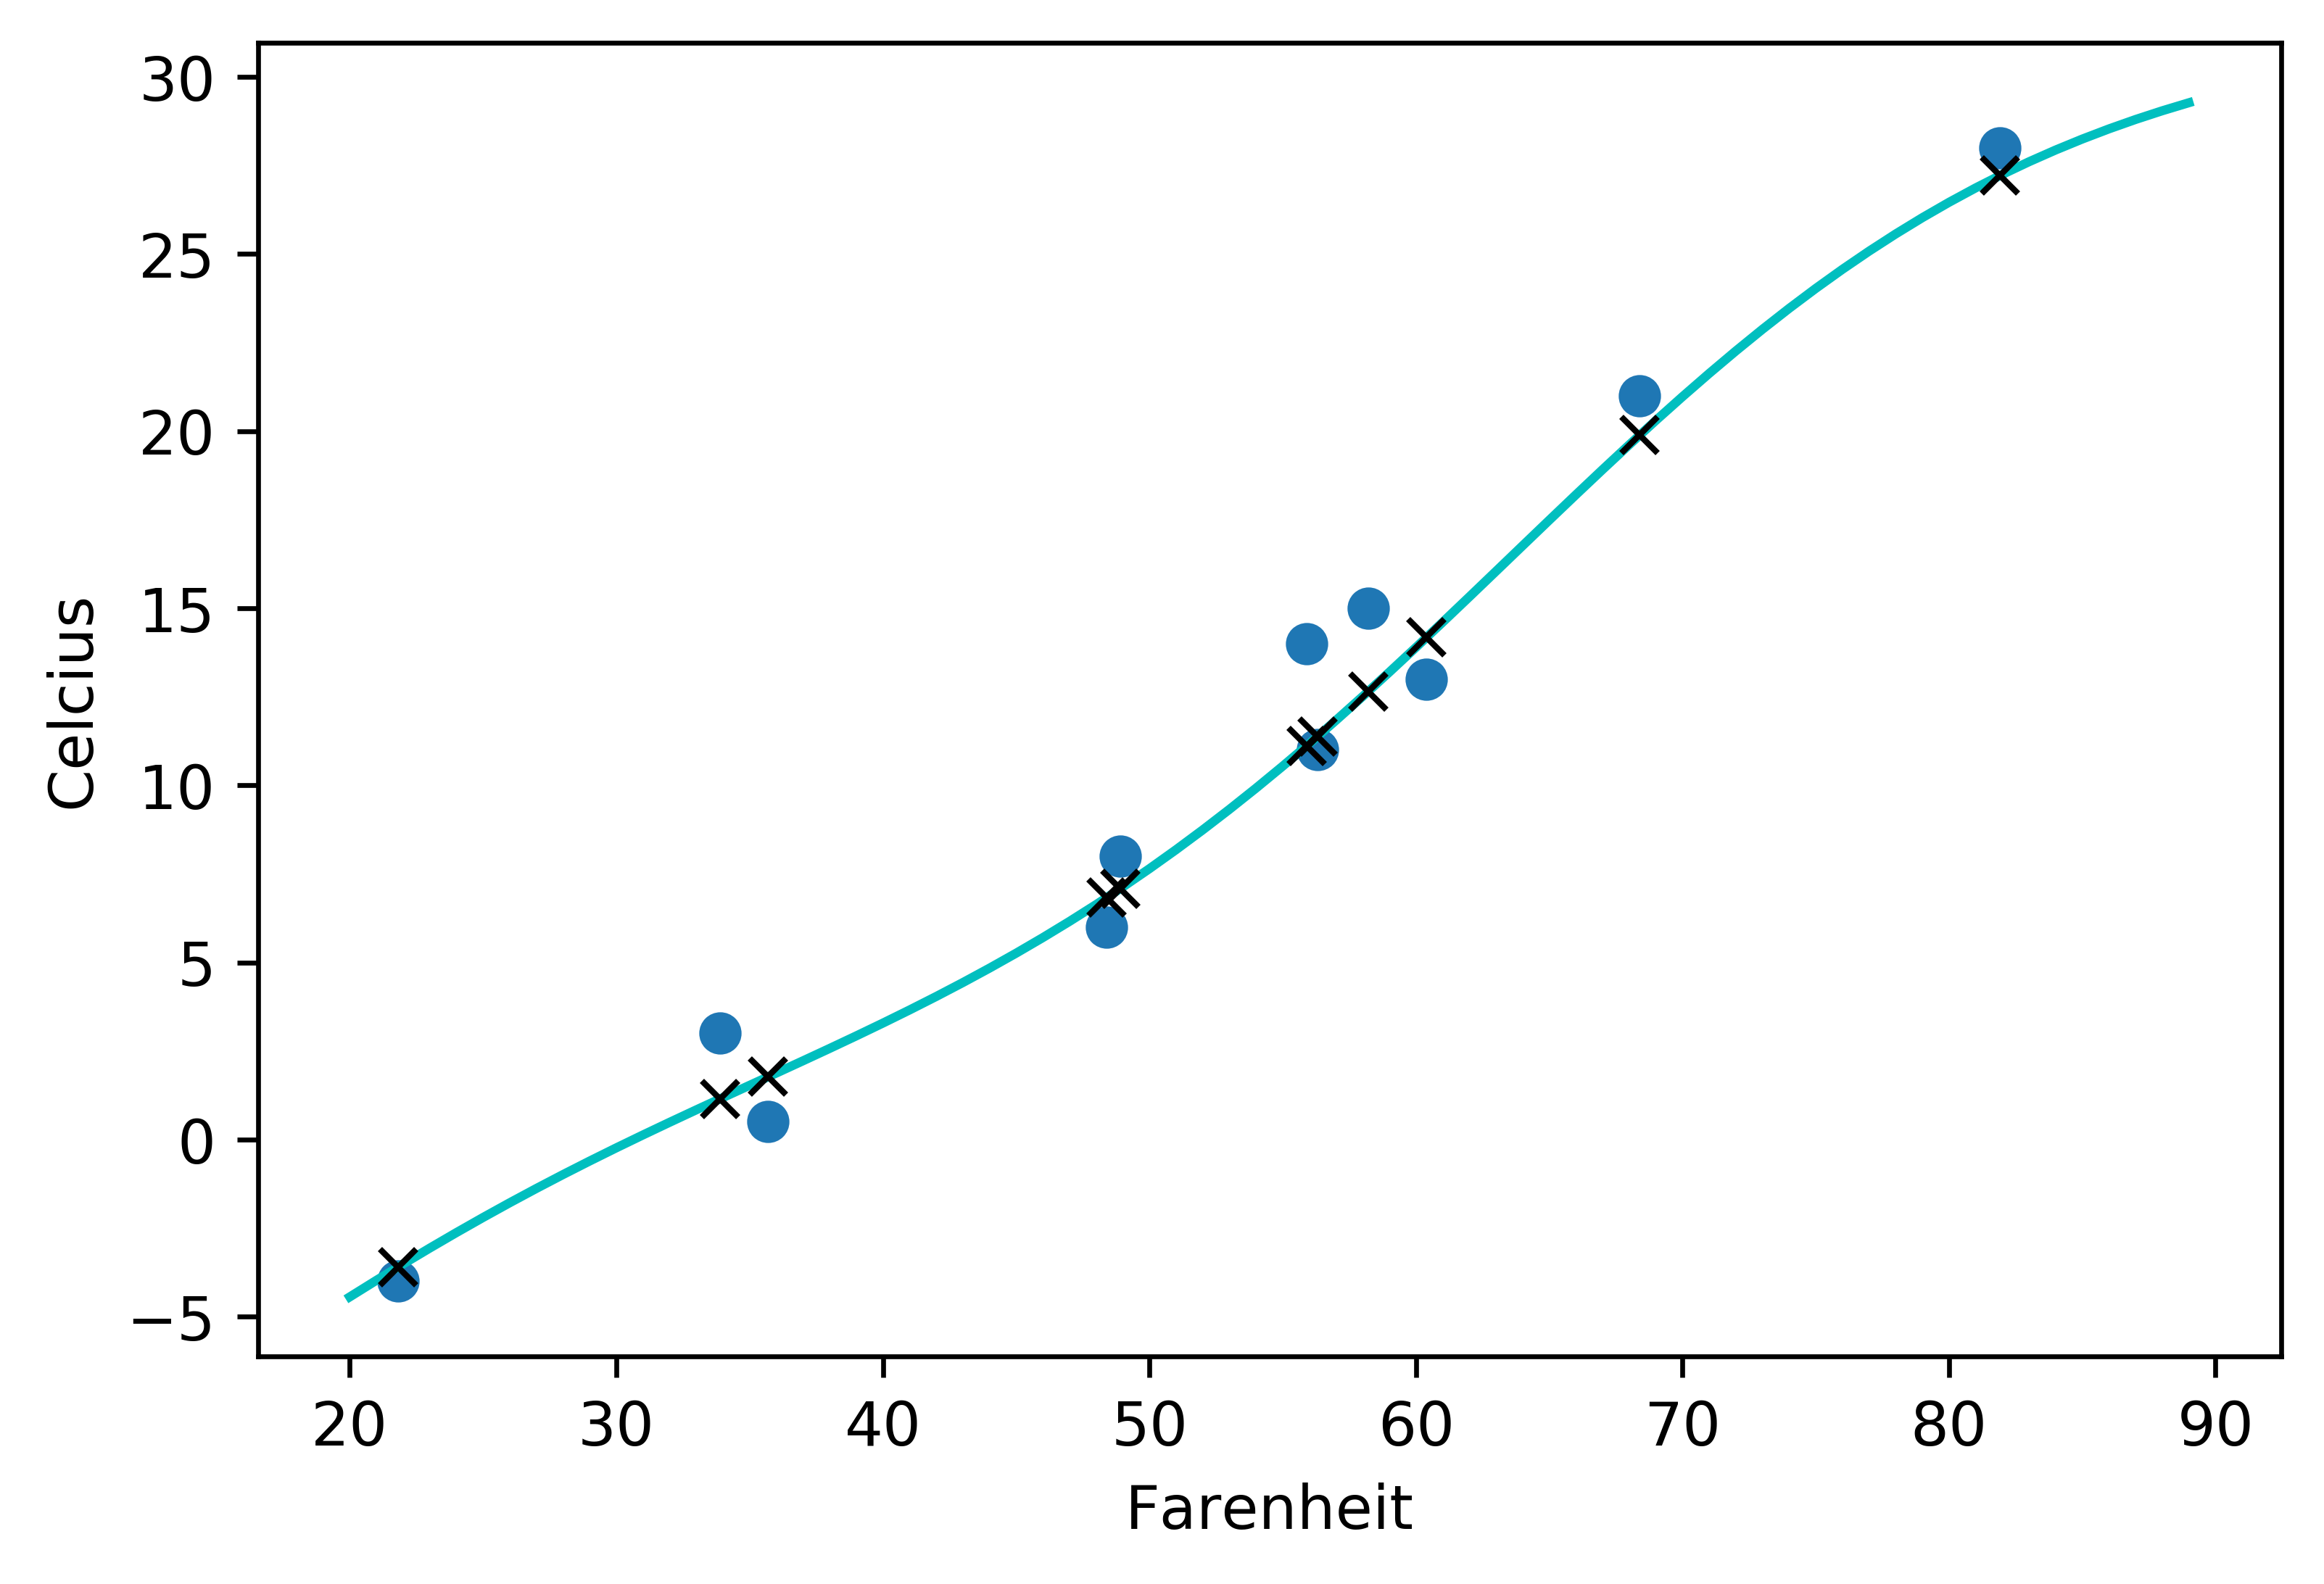

In [23]:
import matplotlib.pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel('Farenheit')
plt.ylabel('Celcius')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [24]:
class SubclassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 13)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(13, 1)
        
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = self.hidden_activation(hidden_t)
        output_t = self.output_linear(activated_t)
        
        return output_t

subclass_model = SubclassModel()
subclass_model
 

SubclassModel(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)